In [45]:
import xarray as xr
import numpy as np
from math import nan
import matplotlib.pyplot as plt

from qtrendutils import linfit_utils as linfit
from qtrendutils import mapplot_utils as maps
from qtrendutils import colorbar_utils as cbars

import importlib
importlib.reload(maps)
import sys

In [46]:
dat = xr.open_dataset("/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/OBS/vaporpressures/vaporpressures_ISD_fromhourly_ge18pd.nc")
dat = dat.sel(time=slice("1980-01","2020-12"))


In [47]:
dat_am = dat.vp.groupby('time.year').mean('time', skipna=False)

In [48]:
isdtrends = xr.apply_ufunc(linfit.compute_slope, dat_am, vectorize=True, input_core_dims=[['year']])*dat_am.year.size

### Dropping stations that have more than 48 months with more than 10 bad days or have a whole year missing

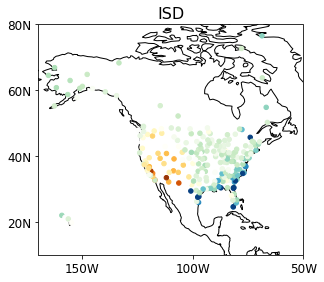

In [49]:
fig = plt.figure(figsize=(16,16))

ax = maps.contourmap_northamerica_scatter_pos(fig, np.array(isdtrends), np.array(dat.lons), np.array(dat.lats),0.1,-2,2,'ISD',
                                                   0.05,0.28,0.77,0.97, cmap="precip")

### Read in the shapefile and grab out the US stations

In [50]:
### Flip the lons to go from -180 to 180
newlons = xr.where(dat['lons'] > 180, dat['lons'] - 360, dat['lons'])
dat['lons'] = newlons

In [51]:
dat = dat.load()

In [52]:
import geopandas as gp
from shapely.geometry import Point

#---First narrow it down by chopping out the longitudes
dat = dat.where( (dat.lons > -150) & (dat.lons < -50), drop=True)
dat = dat.where( (dat.lats > 20) & (dat.lats < 60), drop=True)

shpfile="/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/shp/gadm36_USA_0.shp"
shpcontents = gp.read_file(shpfile)
inus=[]
for i in np.arange(0,dat.lons.size,1):
    print(i)
    inus.append(shpcontents.contains(Point(dat.lons[i], dat.lats[i]))[0])
    
indices = np.argwhere(inus)
datus = dat.isel(station=indices[:,0])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

### Only use CONUS i.e., omit Alaska for working out the Voronoi volumes

In [54]:
conusloc=np.argwhere(np.array(datus.lats) < 55)[:,0]
datconus = datus.isel(station=conusloc)

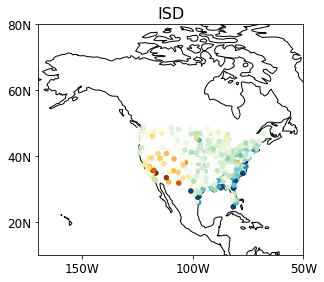

In [55]:
fig = plt.figure(figsize=(16,16))

datconus_am = datconus.groupby('time.year').mean('time')
isdtrends = xr.apply_ufunc(linfit.compute_slope, datconus_am, vectorize=True, input_core_dims=[['year']])*datconus_am.year.size

ax = maps.contourmap_northamerica_scatter_pos(fig, np.array(isdtrends.vp), np.array(datconus.lons), np.array(datconus.lats),0.1,-2,2,'ISD',
                                                   0.05,0.28,0.77,0.97, cmap="precip")

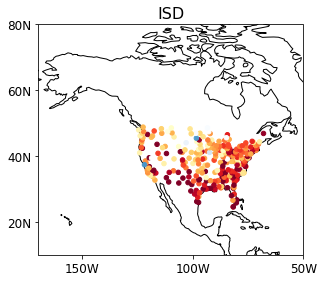

In [56]:
fig = plt.figure(figsize=(16,16))

datconus_am = datconus.groupby('time.year').mean('time')
isdtrends = xr.apply_ufunc(linfit.compute_slope, datconus_am, vectorize=True, input_core_dims=[['year']])*datconus_am.year.size

ax = maps.contourmap_northamerica_scatter_pos(fig, np.array(isdtrends.svp), np.array(datconus.lons), np.array(datconus.lats),0.1,-2,2,'ISD',
                                                   0.05,0.28,0.77,0.97)

### Work out the voronoi volumes

In [58]:
from scipy.spatial import Voronoi, ConvexHull

def voronoi_volumes(points):
    v = Voronoi(points)
    vol = np.zeros(v.npoints)
    for i, reg_num in enumerate(v.point_region):
        indices = v.regions[reg_num]
        if -1 in indices: # some regions can be opened
            vol[i] = np.inf
        else:
            vol[i] = ConvexHull(v.vertices[indices]).volume
    return vol

vol = voronoi_volumes(np.vstack((datconus.lons, datconus.lats)).T)

### Set the stations that have infinite weights to the maximum weight of the other stations (some don't connect because the sea is there)

In [59]:
area_weights = vol
sorted_vals = np.sort(area_weights)

infvalssort = np.argwhere(np.isinf(sorted_vals))
infvals = np.argwhere(np.isinf(area_weights))
area_weights[infvals] = sorted_vals[infvalssort[0]-1]

### Now grab out the 6 state region

In [82]:
shpfilestates="/project/cas/islas/shapefiles/usa/gadm36_USA_1.shp"

import geopandas as gp
shpcontents = gp.read_file(shpfilestates)

states=['California','Colorado','Utah','Nevada','New Mexico','Arizona']
region = shpcontents[shpcontents.NAME_1 == states[0]]
for i in np.arange(1,len(states),1):
    region = region.append(shpcontents[shpcontents.NAME_1 == states[i]])
    
insw=[]
for i in np.arange(0,datconus.lons.size,1):
    insw.append(any(region.contains(Point(datconus.lons[i], datconus.lats[i]))))
    
# grab out the SW stations
indices = np.argwhere(insw)
datsw = datconus.isel(station=indices[:,0])
area_weightsw = area_weights[indices[:,0]]

In [83]:
### Dealing with weights that are too large because they aren't bounded because they're on the coast.
### If the weights are larger than 15 then I'm setting them to the next lowest maximum
area_weightswnew = np.where(area_weightsw < 15, area_weightsw, nan)
area_weightswnew = np.where(np.isnan(area_weightswnew), np.nanmean(area_weightswnew), area_weightsw)

In [67]:
datsw_am = datsw.groupby('time.year').mean('time')

In [ ]:
### Drop stations that have a NaN for any month
dropstat=[]
for istat in np.arange(0,datsw.station.size,1):
    test = datsw.svp.isel(station=istat).sum(skipna=False)
    print(test.values)
    if (np.isnan(test)):
        print('dropping')
        dropstat.append(np.array_str(datsw.station.isel(station=istat).values))

### Check the southwest region and the weights

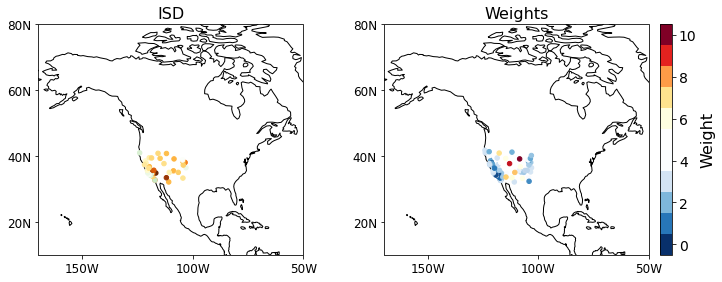

In [17]:
fig = plt.figure(figsize=(16,16))

datsw_am = datsw.groupby('time.year').mean('time')
isdtrends = xr.apply_ufunc(linfit.compute_slope, datsw_am, vectorize=True, input_core_dims=[['year']])*datsw_am.year.size

ax = maps.contourmap_northamerica_scatter_pos(fig, np.array(isdtrends.vp), np.array(datsw.lons), np.array(datsw.lats),0.1,-2,2,'ISD',
                                                   0.05,0.28,0.77,0.97, cmap="precip")

ax = maps.contourmap_northamerica_scatter_pos(fig, np.array(area_weightswnew), np.array(datsw.lons), np.array(datsw.lats),1,0,10,'Weights',
                                             0.35,0.58,0.77,0.97)

ax = cbars.plotcolorbar(fig, 1,0,10,'Weight',0.59,0.6,0.77,0.97,ticks=[0,2,4,6,8,10,12], orient='vertical')


### Assign the weights

In [85]:
area_weightswnew = xr.DataArray(area_weightswnew, coords=[datsw.station], dims=['station'], name='area_weights')

In [86]:
datsw = datsw.assign(area_weights = area_weightswnew)

In [87]:
print(datsw)

<xarray.Dataset>
Dimensions:       (time: 492, station: 68)
Coordinates:
  * station       (station) object '72268023009' '72268793033' ... '74718823158'
  * time          (time) datetime64[ns] 1980-01-16 ... 2020-12-16
Data variables:
    relhum        (time, station) float64 58.51 60.51 46.81 ... 30.57 20.57
    svp           (time, station) float64 8.074 9.35 9.994 ... 10.46 14.24 14.59
    vp            (time, station) float64 4.731 5.666 4.69 ... 6.562 4.371 3.014
    vpd           (time, station) float64 3.343 3.684 5.304 ... 3.901 9.87 11.57
    lons          (station) float64 -104.5 -104.3 -107.3 ... -116.2 -114.7
    lats          (station) float64 33.31 32.33 33.24 ... 36.33 33.63 33.62
    nbaddays      (station, time) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 1.0
    area_weights  (station) float64 3.723 1.321 5.928 ... 1.045 2.362 7.374


In [88]:
datsw = datsw.drop_sel(station=dropstat)
area_weightswnew = area_weightswnew.drop_sel(station=dropstat)

In [90]:
vp_sw = (datsw.vp*datsw.area_weights).sum('station') / np.sum(datsw.area_weights)
vp_sw = vp_sw.rename('vp')
vpd_sw = (datsw.vpd*datsw.area_weights).sum('station') / np.sum(datsw.area_weights)
vpd_sw = vpd_sw.rename('vpd')
svp_sw = (datsw.svp*datsw.area_weights).sum('station') / np.sum(datsw.area_weights)
svp_sw = svp_sw.rename('svp')
relhum_sw = (datsw.relhum*datsw.area_weights).sum('station') /np.sum(datsw.area_weights)
relhum_sw = relhum_sw.rename('relhum')

In [94]:
swavgs = xr.merge([vp_sw, vpd_sw, svp_sw, relhum_sw])

In [95]:
swavgs.to_netcdf("/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/USSW/vaporpressures/vaporpressures_ISD_USSW_fromhourly_ge18pd.nc")